<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-sample-file" data-toc-modified-id="Load-sample-file-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load sample file</a></span></li><li><span><a href="#Check-Physics-tendencies" data-toc-modified-id="Check-Physics-tendencies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check Physics tendencies</a></span></li><li><span><a href="#Test-moisture-and-MSE-conservation" data-toc-modified-id="Test-moisture-and-MSE-conservation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test moisture and MSE conservation</a></span><ul class="toc-item"><li><span><a href="#Compute-the-vertical-pressure-difference" data-toc-modified-id="Compute-the-vertical-pressure-difference-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Compute the vertical pressure difference</a></span></li><li><span><a href="#Moisture-budget" data-toc-modified-id="Moisture-budget-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Moisture budget</a></span></li><li><span><a href="#Moist-static-energy-budget" data-toc-modified-id="Moist-static-energy-budget-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Moist static energy budget</a></span></li></ul></li><li><span><a href="#Questions" data-toc-modified-id="Questions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Questions</a></span></li></ul></div>

# Energy conservation

Check how variables relate to conserve energy. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load sample file

In [2]:
# Load one file (containing one day)
ds = xr.open_dataset(
    '/project/meteo/w2w/A6/S.Rasp/SP-CAM/Aquaplanet_new/AndKua_aqua_SPCAM3.0_enhance01.cam2.h1.0000-01-02-00000.nc',
    decode_times=False
)

In [45]:
ds

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 48)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * lon           (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 912.6 887.0 859.5 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 90.01 90.02 90.04 ...
  * time          (time) float64 1.0 1.021 1.042 1.062 1.083 1.104 1.125 ...
Dimensions wi

In [46]:
# Load a smaller dataset with only three time steps to speed up things
ds = ds.isel(time=[0, 1, 2])

In [48]:
ds.SPDQ.shape

(3, 30, 64, 128)

In [53]:
ds.VD01

<xarray.DataArray 'VD01' (time: 3, lev: 30, lat: 64, lon: 128)>
array([[[[  0.000000e+00, ...,   0.000000e+00],
         ..., 
         [  0.000000e+00, ...,   0.000000e+00]],

        ..., 
        [[  3.164698e-08, ...,   3.754981e-08],
         ..., 
         [  7.763678e-08, ...,   8.436302e-08]]],


       ..., 
       [[[  0.000000e+00, ...,   0.000000e+00],
         ..., 
         [  0.000000e+00, ...,   0.000000e+00]],

        ..., 
        [[  3.438671e-08, ...,   3.586403e-08],
         ..., 
         [  7.715597e-08, ...,   7.335777e-08]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 -71.16 ...
  * lon      (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 19.69 ...
  * lev      (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 87.82 ...
  * time     (time) float64 1.0 1.021 1.042
Attributes:
    units:        kg/kg/s
    long_name:    Vertical diffusion of Q
    cell_method:  time: mean

## Check Physics tendencies

TPHYSTND is the sum of all physical tendencies. For SP-CAM on an Aquaplanet this should be approximately:

TPHYSTND = SPDT + DTV + QRS + QRL

Similarly for moisture:

PHQ = SPDQ + VD01

Let's see how large the residual is.

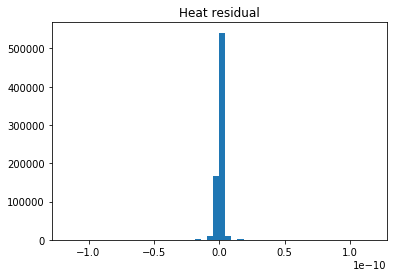

In [51]:
plt.hist(
    np.ravel(ds.TPHYSTND.values) -
    np.ravel(ds.SPDT.values + ds.DTV.values + ds.QRL.values + ds.QRS.values),
    bins=50
);
plt.title('Heat residual');

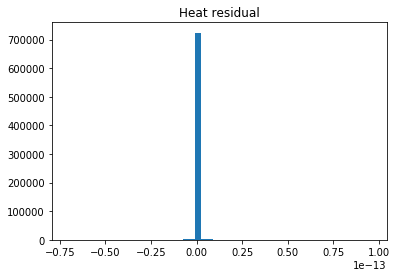

In [52]:
plt.hist(
    np.ravel(ds.PHQ.values) -
    np.ravel(ds.SPDQ.values + ds.VD01.values),
    bins=50
);
plt.title('Heat residual');

So the residuals are basically zero. Sanity check passed!

## Test moisture and MSE conservation

We want to test the moisture budget

vint(SPDQ + VD01) \* L_V = LHFLX - PRECT \* 1e3 \*L_V

and the MSE budget

vint(SPDT + DTV) \* C_P + vint(DPDQ + VD01) \* L_V = SHFLX + LHFLX

### Compute the vertical pressure difference

To do the vertical integrations, we need to compute the pressure differences. The actual pressure is computed as

p = P0 \* hyai + PS \* hybi

Then we can compute the vertical integrals as

vint(SPDQ) = sum(SPDQ \* p_diff) * L_V / G


In [54]:
def get_p_diff(ds):
    p = ds.P0 * ds.hyai + ds.PS * ds.hybi
    p_diff = np.diff(p.values, axis=0)
    return np.rollaxis(p_diff, 0, 2)

In [55]:
p_diff = get_p_diff(ds)

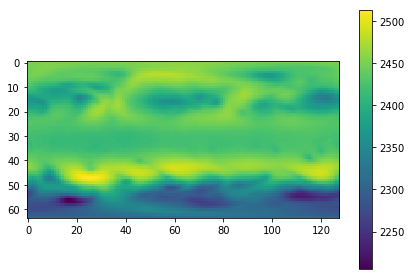

In [70]:
plt.imshow(p_diff[1, -5, :, :])
plt.colorbar()
plt.tight_layout()

### Moisture budget

In [71]:
L_V = 2.5e6   # Latent heat of vaporization is actually 2.26e6
C_P = 1e3 # Specific heat capacity of air at constant pressure
G = 9.81

In [81]:
def vint(x, factor):
    return np.sum(x.values * factor * p_diff / G, 1)

In [73]:
SPDQ_vint = vint(ds.SPDQ, L_V)

In [74]:
VD01_vint = vint(ds.VD01, L_V)

In [75]:
def scat(x, y):
    plt.scatter(np.ravel(x), np.ravel(y))
    plt.show()

In [92]:
def hist(x):
    plt.hist(np.ravel(x), bins=50)
    plt.show()

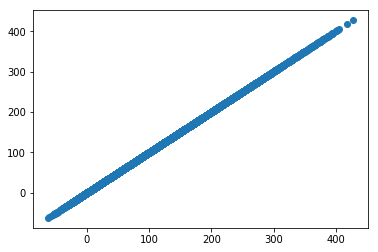

In [76]:
scat(VD01_vint, ds.LHFLX)

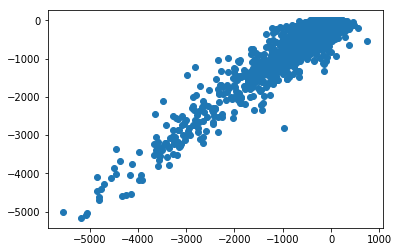

In [77]:
scat(SPDQ_vint, ds.PRECT * -1e3 * L_V)

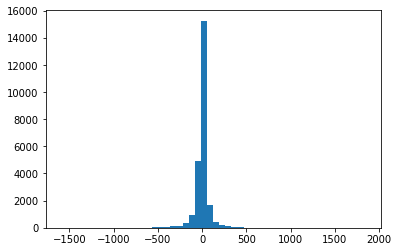

In [94]:
hist(SPDQ_vint - (ds.PRECT * -1e3 * L_V))

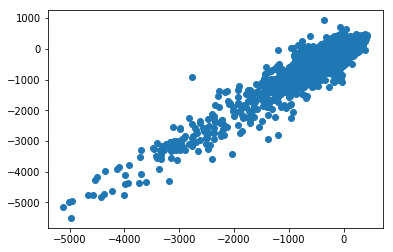

In [85]:
scat(ds.LHFLX - ds.PRECT * 1e3 * L_V, SPDQ_vint + VD01_vint)

### Moist static energy budget

In [82]:
SPDT_vint = vint(ds.SPDT, C_P)

In [83]:
DTV_vint = vint(ds.DTV, C_P)

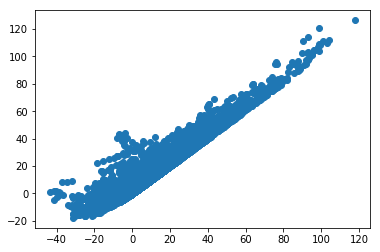

In [101]:
scat(ds.SHFLX, DTV_vint)

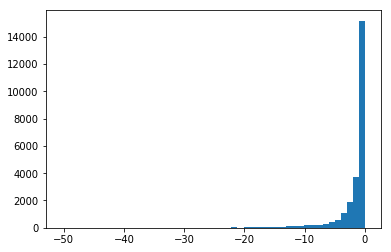

In [100]:
hist(ds.SHFLX - DTV_vint)

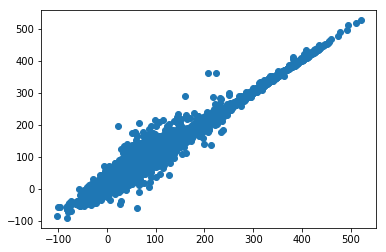

In [96]:
scat(ds.LHFLX + ds.SHFLX, SPDQ_vint + VD01_vint + SPDT_vint + DTV_vint)

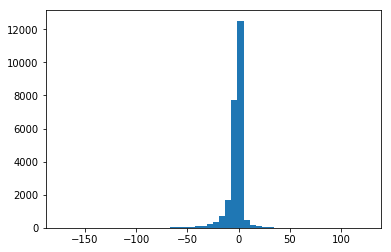

In [98]:
hist(ds.LHFLX + ds.SHFLX - (SPDQ_vint + VD01_vint + SPDT_vint + DTV_vint))

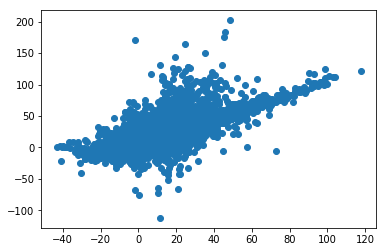

In [97]:
scat(ds.SHFLX, SPDQ_vint + SPDT_vint + DTV_vint)

## Questions

1. Why is VD01 = LHFLX but DTV != SHFLX?
2. What is added SHFLX --> DTV?
3. Why is SPDQ_vint != PRECT?
4. What else except for (2.) is missing in SHFLX = SPDQ + SPDT + DTV?